# Project
## Neural translation model
### Instructions

In this notebook, I will create a neural network that translates from English to German.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re

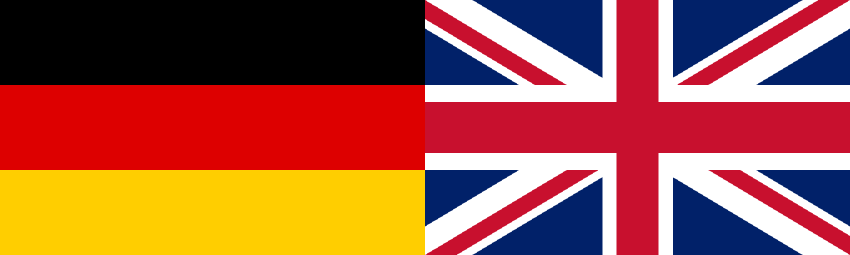
For the capstone project, I will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, I will restrict to the dataset to 20,000 pairs. 

The goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

In [3]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('drive/MyDrive/RNN/data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture I will develop in this project.

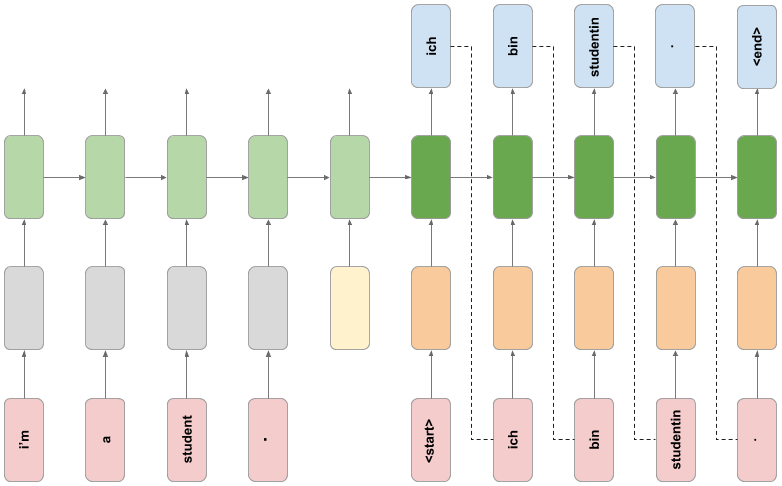

Key:
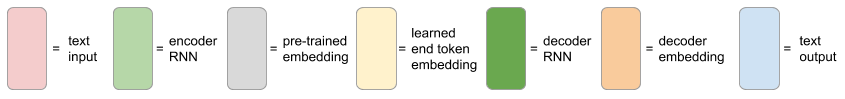
The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [5]:
english_sentences = []
german_sentences = []
for i in data_examples:
    t = i.split('\t')
    english_sentences.append(preprocess_sentence(t[0]))
    german_sentences.append('<start> '+preprocess_sentence(t[1])+' <end>')

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)

In [7]:
import numpy as np
ran_index = np.random.randint(0, 200, size=10)
for i in ran_index:
    print(f'Eng: {english_sentences[i]}, Ger: {german_sentences[i]},\n Token: {tokenizer.texts_to_sequences([german_sentences[i]])}')

Eng: got it ?, Ger: <start> kapiert ? <end>,
 Token: [[1, 2262, 7, 2]]
Eng: got it ?, Ger: <start> kapiert ? <end>,
 Token: [[1, 2262, 7, 2]]
Eng: go away ., Ger: <start> verpiss dich ! <end>,
 Token: [[1, 1765, 28, 9, 2]]
Eng: keep it ., Ger: <start> behalt es ! <end>,
 Token: [[1, 787, 10, 9, 2]]
Eng: go away !, Ger: <start> mach dich fort ! <end>,
 Token: [[1, 79, 28, 445, 9, 2]]
Eng: hop in ., Ger: <start> mach mit ! <end>,
 Token: [[1, 79, 55, 9, 2]]
Eng: perfect !, Ger: <start> perfekt ! <end>,
 Token: [[1, 422, 9, 2]]
Eng: it's ok ., Ger: <start> es ist in ordnung . <end>,
 Token: [[1, 10, 6, 46, 225, 3, 2]]
Eng: see you ., Ger: <start> wir sehen uns . <end>,
 Token: [[1, 17, 114, 31, 3, 2]]
Eng: i'll go ., Ger: <start> ich gehe . <end>,
 Token: [[1, 4, 133, 3, 2]]


In [8]:
def padding_sequence(sequences):
    return tf.keras.preprocessing.sequence.pad_sequences(
    sequences, dtype='int32', padding='post', value=0)

In [9]:
ran_index = np.random.randint(0, 200, size=10)
for i in ran_index:
    print(f'Eng: {english_sentences[i]}, Ger: {german_sentences[i]},\n Token: {padding_sequence(tokenizer.texts_to_sequences([german_sentences[i]]))}')

Eng: push it ., Ger: <start> drueck drauf . <end>,
 Token: [[   1 1226 1237    3    2]]
Eng: beat it ., Ger: <start> mach dich vom acker ! <end>,
 Token: [[   1   79   28  576 1228    9    2]]
Eng: go away ., Ger: <start> zisch ab ! <end>,
 Token: [[   1 1231  125    9    2]]
Eng: he ran ., Ger: <start> er rannte . <end>,
 Token: [[  1  14 359   3   2]]
Eng: go away ., Ger: <start> zisch ab ! <end>,
 Token: [[   1 1231  125    9    2]]
Eng: no way !, Ger: <start> in keinster weise ! <end>,
 Token: [[   1   46 3164  542    9    2]]
Eng: i paid ., Ger: <start> ich zahlte . <end>,
 Token: [[   1    4 2264    3    2]]
Eng: i'm old ., Ger: <start> ich bin alt . <end>,
 Token: [[  1   4  15 179   3   2]]
Eng: hug tom ., Ger: <start> umarme tom ! <end>,
 Token: [[   1 2263    5    9    2]]
Eng: hug tom ., Ger: <start> drueckt tom ! <end>,
 Token: [[   1 1768    5    9    2]]


## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, I will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1. This module has also been made available as a complete saved model in the folder `'./models/tf2-preview_nnlm-en-dim128_1'`. 

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [10]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [11]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

Now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is more than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method.
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [12]:
eng_data = english_sentences
ger_data = padding_sequence(tokenizer.texts_to_sequences(german_sentences))

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((eng_data[:16000],ger_data[:16000]))
test_dataset = tf.data.Dataset.from_tensor_slices((eng_data[16000:],ger_data[16000:]))

In [14]:
def split_eng(x, y):
    return tf.strings.split(x), y
train_dataset = train_dataset.map(split_eng)
test_dataset = test_dataset.map(split_eng)

In [15]:
def embedding_sequence(x, y):
    return embedding_layer(x), y
train_dataset = train_dataset.map(embedding_sequence)
test_dataset = test_dataset.map(embedding_sequence)

In [16]:
def filter_13(x, y):
    return tf.shape(x)[0] <= 13
train_dataset = train_dataset.filter(filter_13)
test_dataset = test_dataset.filter(filter_13)

In [17]:
def padding(x, y):
    return tf.pad(x, paddings=[[13-tf.shape(x)[0],0],[0,0]] ,mode='CONSTANT', constant_values=0), y
train_dataset = train_dataset.map(padding)
test_dataset = test_dataset.map(padding)

In [18]:
train_dataset=train_dataset.batch(16)
test_dataset=test_dataset.batch(16)

In [19]:
train_dataset.element_spec
test_dataset.element_spec

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))

In [20]:
for x, y in train_dataset.take(1):
    print(x.shape)
for x, y in test_dataset.take(1):
    print(y)

(16, 13, 128)
tf.Tensor(
[[   1   11    6  106  538    3    2    0    0    0    0    0    0    0]
 [   1   11    6   19 5102    3    2    0    0    0    0    0    0    0]
 [   1   47  427    6  428    3    2    0    0    0    0    0    0    0]
 [   1   26 1425 2739 5103    3    2    0    0    0    0    0    0    0]
 [   1   26 1425    6  325    9    2    0    0    0    0    0    0    0]
 [   1   11 1373    6  360    3    2    0    0    0    0    0    0    0]
 [   1   26 5104    6  938    3    2    0    0    0    0    0    0    0]
 [   1   26  591   67    3    2    0    0    0    0    0    0    0    0]
 [   1   26  591   25   67    3    2    0    0    0    0    0    0    0]
 [   1   47 1584    6  328    3    2    0    0    0    0    0    0    0]
 [   1   11  113    6   33    3    2    0    0    0    0    0    0    0]
 [   1   11  113    6  584    3    2    0    0    0    0    0    0    0]
 [   1   11  113    6   84    3    2    0    0    0    0    0    0    0]
 [   1   26 2227    6  938

## 3. Create the custom layer
Create a custom layer to add the learned end token embedding to the encoder model:

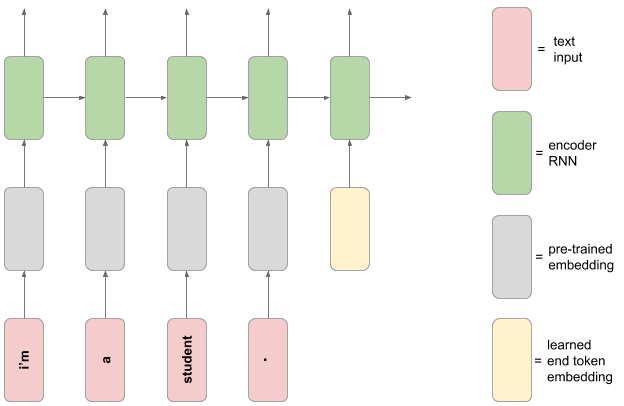

Build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space).
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [21]:
class EnglishEndLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EnglishEndLayer, self).__init__(**kwargs)
        self.embeded = tf.Variable(initial_value=tf.zeros(shape=(1,128)), trainable=True, dtype='float32')
    def call(self, inputs):
        x = tf.tile(self.embeded, [tf.shape(inputs)[0], 1])
        x = tf.expand_dims(x, axis=1)
        return tf.concat([inputs, x], axis=1)
        

In [22]:
custom_layer = EnglishEndLayer()
x, y = next(iter(train_dataset.take(1)))

## 4. Build the encoder network
The encoder network follows the schematic diagram above. Now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer I created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value I used when I padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [24]:
inputs = tf.keras.Input(batch_shape = (None, 13, 128), name='input')
x = EnglishEndLayer(name='custom_layer')(inputs)
x = tf.keras.layers.Masking(mask_value=0, name='masking_layer')(x)
x, h, c = tf.keras.layers.LSTM(units=512, return_state=True, name='lstm')(x)
encoder_model = tf.keras.Model(inputs = inputs, outputs = [h, c], name='encoder')
 
encoder_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 13, 128)]         0         
_________________________________________________________________
custom_layer (EnglishEndLaye (None, 14, 128)           128       
_________________________________________________________________
masking_layer (Masking)      (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

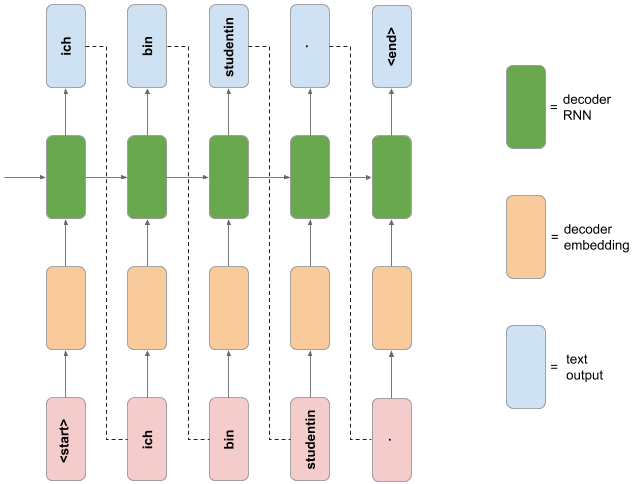

Build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [25]:
class DecoderModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(DecoderModel, self).__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=128, mask_zero=True, name='embedding_layer')
        self.lstm = tf.keras.layers.LSTM(512, return_state = True, return_sequences = True, name='lstm_layer')
        self.fc = tf.keras.layers.Dense(len(tokenizer.index_word)+1, name='fc_layer')
    def call(self, inputs, hidden_state = None, cell_state = None):
        x = self.embed(inputs)
        x, hidden_state, cell_state = self.lstm(x, initial_state = [hidden_state, cell_state]) \
                                                     if hidden_state is not None and cell_state is not None else self.lstm(x)
        x = self.fc(x)
        return x, hidden_state, cell_state

In [26]:
x, y = next(iter(train_dataset.take(1)))
hidden_state, cell_state = encoder_model(x)
decoder_model = DecoderModel()
g_out, h, c = decoder_model(y, hidden_state, cell_state)
print(g_out.shape, h.shape, c.shape)

(16, 14, 5744) (16, 512) (16, 512)


In [27]:
print(g_out.shape, x.shape, y.shape)

(16, 14, 5744) (16, 13, 128) (16, 14)


In [28]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  multiple                  735232    
_________________________________________________________________
lstm_layer (LSTM)            multiple                  1312768   
_________________________________________________________________
fc_layer (Dense)             multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
Now write a custom training loop to train the custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for the translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with @tf.function
* Define and run a custom training loop for a number of epochs that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [71]:
def get_german_decoder_data(g):
    return tf.constant(np.where(g.numpy() == 2, 0, g.numpy())), tf.constant(np.where(np.roll(g.numpy(), -1) == 1, 0, np.roll(g.numpy(), -1)))

In [30]:
@tf.function
def forward_backward(encoder_model, decoder_model, e, g_in, g_out, loss):
    with tf.GradientTape() as tape:
        h, c = encoder_model(e)
        d_g_out, _, _ = decoder_model(g_in, h, c)
        cur_loss = loss(g_out, d_g_out)
        grads = tape.gradient(cur_loss, encoder_model.trainable_variables + decoder_model.trainable_variables)
    return cur_loss, grads

In [31]:
def train_encoder_decoder(encoder_model, decoder_model, num_epochs, train_data, valid_data, valid_steps, 
                          optimizer, loss, grad_fn):
    train_losses = []
    val_loasses = []
    for epoch in range(num_epochs):
        train_epoch_loss_avg = tf.keras.metrics.Mean()
        val_epoch_loss_avg = tf.keras.metrics.Mean()
        for e, g in train_data:
            g_in, g_out = get_german_decoder_data(g)
            train_loss, grads = grad_fn(encoder_model, decoder_model, e, g_in, g_out, loss)
            optimizer.apply_gradients(zip(grads, encoder_model.trainable_variables + decoder_model.trainable_variables))
            train_epoch_loss_avg.update_state(train_loss)    
        for e_v, g_v in valid_data.take(valid_steps):
            g_v_in, g_v_out = get_german_decoder_data(g_v)
            val_loss, _ = grad_fn(encoder_model, decoder_model, e_v, g_v_in, g_v_out, loss)
            val_epoch_loss_avg.update_state(val_loss)        
        print(f'epoch: {epoch}, train loss: {train_epoch_loss_avg.result()}, validation loss: {val_epoch_loss_avg.result()}')    
        train_losses.append(train_epoch_loss_avg.result())
        val_loasses.append(val_epoch_loss_avg.result())
    return train_losses, val_loasses

In [36]:
optimizer_obj = tf.keras.optimizers.Adam(learning_rate = 1e-3)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_loss_results, valid_loss_results = train_encoder_decoder(encoder_model, decoder_model, 10, train_dataset, test_dataset, 20,
                                                          optimizer_obj, loss_obj, forward_backward)

epoch: 0, train loss: 3.1517016887664795, validation loss: 2.9039950370788574
epoch: 1, train loss: 2.206493377685547, validation loss: 2.2406632900238037
epoch: 2, train loss: 1.4799106121063232, validation loss: 1.8219022750854492
epoch: 3, train loss: 1.0028012990951538, validation loss: 1.5409154891967773
epoch: 4, train loss: 0.7259365320205688, validation loss: 1.4158079624176025
epoch: 5, train loss: 0.5552237033843994, validation loss: 1.3550398349761963
epoch: 6, train loss: 0.44191327691078186, validation loss: 1.347861409187317
epoch: 7, train loss: 0.360580176115036, validation loss: 1.3037381172180176
epoch: 8, train loss: 0.30624163150787354, validation loss: 1.3161907196044922
epoch: 9, train loss: 0.265109658241272, validation loss: 1.293156385421753


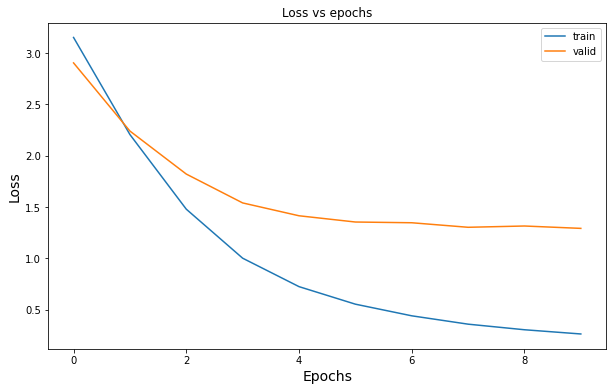

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title('Loss vs epochs')
plt.plot(train_loss_results, label='train')
plt.plot(valid_loss_results, label='valid')
plt.legend()
plt.show()

## 7. Use the model to translate
Now it's time to put the model into practice! I run the translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [70]:
indices = np.random.choice(len(english_sentences), 5)
test_data = tf.data.Dataset.from_tensor_slices(np.array([english_sentences[i] for i in indices]))
test_data = test_data.map(tf.strings.split)
test_data = test_data.map(embedding_layer)
test_data = test_data.filter(lambda x: tf.shape(x)[0] <= 13)
test_data = test_data.map(lambda x: tf.pad(x, paddings = [[13-tf.shape(x)[0],0], [0,0]], mode='CONSTANT', constant_values=0))
 
start_token = np.array(tokenizer.texts_to_sequences(['<start>']))
end_token = np.array(tokenizer.texts_to_sequences(['<end>']))
print(test_data)
for e, i in zip(test_data.take(1), indices):

    word_len = 1
    h, c = encoder_model(tf.expand_dims(e, axis=0))
    g_t = []
    g_in = start_token
    g_out, h, c = decoder_model(g_in, h, c)
    g_t.append('')
    g_out = tf.argmax(g_out, axis=2)
    while g_out != end_token: 
        g_out, h, c = decoder_model(g_in, h, c)
        g_out = tf.argmax(g_out, axis=2)
        g_in = g_out
        word_len += 1
        if g_out == end_token or word_len > 14:
          break
        g_t.append(tokenizer.index_word.get(tf.squeeze(g_out).numpy(), 'UNK'))
        
    print(f'English Text: {english_sentences[i]}')
    print(f'German Translation: {" ".join(g_t)}')
    print()

<MapDataset shapes: (None, 128), types: tf.float32>
English Text: i can't do it .
German Translation:  ich kann es reparieren .

